<a href="https://colab.research.google.com/github/Berkan66/CV-Group-Assignment-1/blob/master/CV__Group_assignment_group6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Group assignment - Computer Vision - Group 6**

Members: Berkan Aktag, Robbe Bresseleers, Stefan Torben Funk, Guojun Wu

In [0]:
import os
import cv2
import tarfile
import numpy as np
from urllib import request
import urllib
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# **3. Build a faces dataset**
The following code downloads all the needed faces from an online [Github Repository](https://https://github.com/Berkan66/CV-Images-repo). The reason for using this is to speed up the processing time. The face extraction and downloading of images is all been done by the given code in the (initial) assignment. (This process takes between 20-30 seconds)


**Person A = Katheryn Winnick**, Female/Blond/White, she has nice similarities with person C and clear distinguisable from person B and D.

**Person B = Kevin Hart**, Male/Buzz Cut/Black, she has nice similarities with person D and clear distinguisable from person A and C

**Person C = Natalie Dormer**, Female/Blond/White, she has nice similarities with person A and clear distinguisable from person B and D

**Person D = Usher Raymond**, Male/Buzz Cut/Black, she has nice similarities with person D and clear distinguisable from person A and C

**Grayscale** plot of all the 80 images used in this assignment. The images are **resized to (80, 80).**

There are 30 images for person A and B (each with 20 training and 10 test images) and 10 testing images for person C and D.

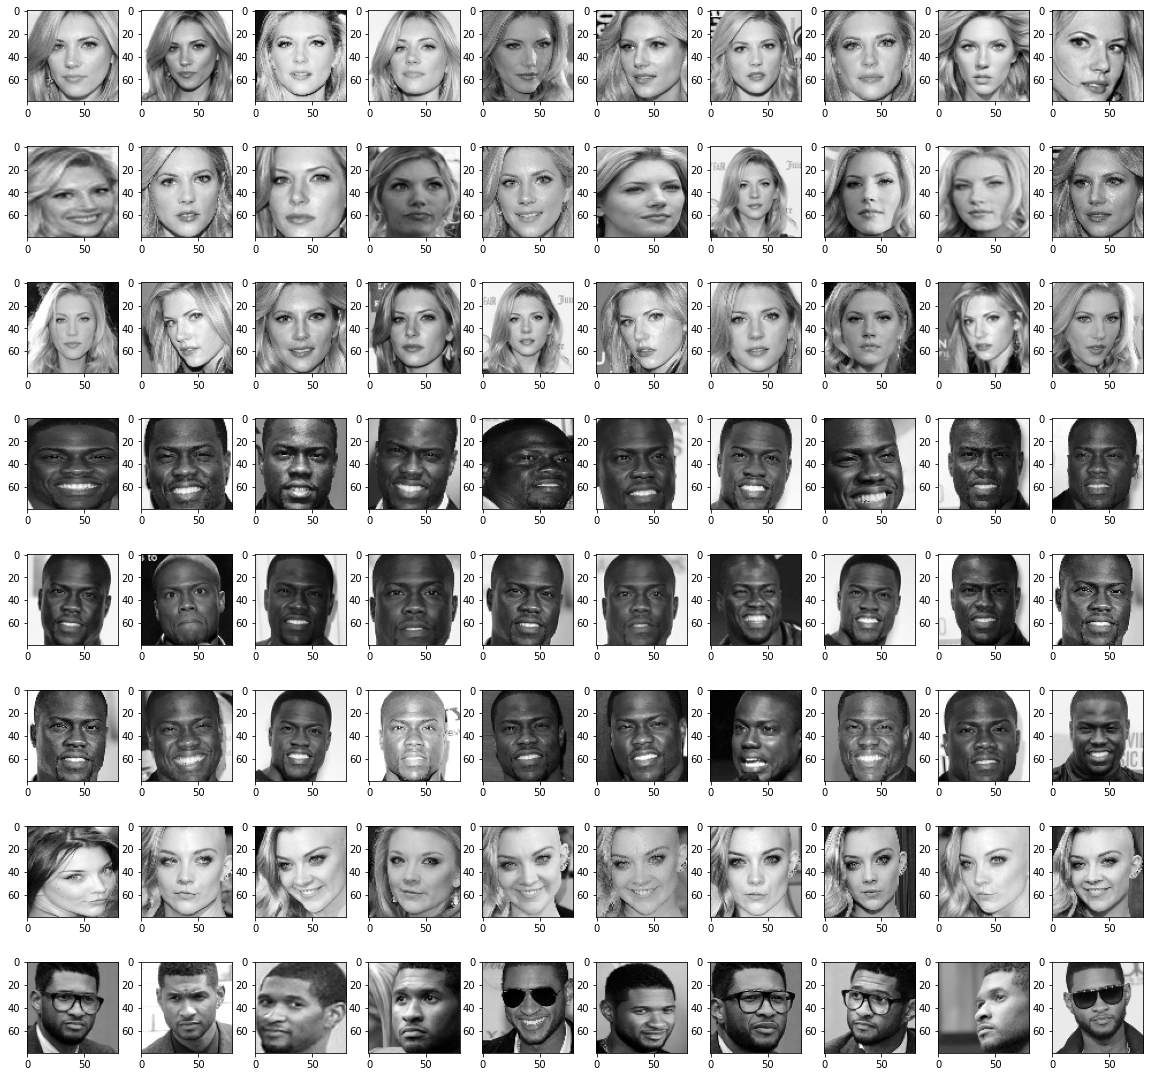

In [0]:
base_repo_path = "https://raw.githubusercontent.com/Berkan66/CV-Images-repo/master/"

images__ = []
for line in urllib.request.urlopen("https://raw.githubusercontent.com/Berkan66/CV-Images-repo/master/celeb_pictures.txt"):
    img_url = line.decode('utf-8')

    image_path = base_repo_path + "Images/" + img_url
    url = image_path[image_path.find("https://"): image_path.find(".jpg") + 4]
    try:
      res = request.urlopen(url)
      img = np.asarray(bytearray(res.read()), dtype="uint8")
      img = cv2.imdecode(img, cv2.IMREAD_COLOR)
      images__.append(img)
    except:
      raise

faces = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images__]
faces = [cv2.resize(img, (80, 80), interpolation=cv2.INTER_CUBIC) for img in faces]

sz = faces[0].shape
data = np.zeros((len(faces), sz[0] * sz[1]), dtype=np.uint8)
for i in range(len(faces)):
    data[i, :] = faces[i].flatten()
f, axs = plt.subplots(8,10, figsize=(20,20))
plt.subplots_adjust(hspace=0.00, wspace=0.25)

for i in range(8):
    for j in range(10):
        axs[i,j].imshow(faces[i*10+j], cmap=plt.cm.gray)

# **4. Feature representations**



Create target labels for the images and divide the faces of person A and B. The purpose of this is to have an equal training/test set. This is later used for classification.

In [0]:
# Divide person A and B faces, create target labels

# Faces of person A and B
kat = faces[0:30]
hart = faces[30:60]

# Target labels for person A, B, C, D
target_label_A = np.zeros(30)
target_label_B = np.ones(30)
target_label_C = np.zeros(10)
target_label_D = np.ones(10)

# Create target labels (0 for person A, 1 for person B)
target = np.concatenate((target_label_A, target_label_B, target_label_C, target_label_D))

## **4.1 Handcrafted features - HOG**


**0. Compare HOG to grabbing** 

HOG is similar to grabbing an object in the sense that they both rely heavily on the detection of edges in an image. In the case of grabbing, edges are used to segment an image and isolate the segment that (hopefully) corresponds to the desired object. In the previous assignment this was done with Sobel and Canny edge detection, HOG depends also on this because it makes use of sobel in the implemenation. With HOG, the ‘strength’ and direction of edges in a particular area are used to determine features present in that area (see part 6. for more details). 

**1.1 HOG Feature Extraction - OpenCV**

Hog feature extraction with the inbuilt function of opencv: [HOGDescriptor](https://docs.opencv.org/3.4.9/d5/d33/structcv_1_1HOGDescriptor.html)

The distance between the feature vectors are calculated with euclidean distance. Person A is matched with another image of person A and B, and person B is matched with B and A. 

The **feature vector** has a size of **11664 x 1** vector. The parameters of the functions are as follow:


*   **winSize**: 80 by 80 to capture only one feature (e.g.: the person is a male or female) 
*   **cellSize**: 10 by 10, the value is based on the scale of the features important to do the classification. The small value of the cell size is one the reasons for the large feature vector.
*   **blockSize**: 40 by 40, a large value is chosen to make local changes less significant (since we want to capture the big picture). 
*   **blockStride**: 10 by 10 to have some overlapping between the neighbouring blocks (this increased the accuracy of the classifier a lot). 
*   The other parameters are the default parameters from [learnopencv](https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/), changing these did not give any better results.

The only pre-processing steps used in this assignment is resizing the images. Normalizing the images (dividing by 255) gives a better feature distance for person A but not for person B. Therefor we did not use it in our program.

In [0]:
features = np.zeros((len(faces), 11664))

def calculate_hog(winSize, blockSize, blockStride, cellSize):
  nbins = 9
  derivAperture = 1
  winSigma = -1.
  histogramNormType = 0
  L2HysThreshold = 0.2
  gammaCorrection = 1
  nlevels = 64
  signedGradients = True

  winStride= (8, 8)
  padding = (8, 8)

  hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)

  for idx, face in enumerate(faces):
    locations = []
    face = face.astype(np.uint8)
    hist = hog.compute(face, winStride, padding, locations)
    features[idx] = hist.flatten()

calculate_hog(winSize = (80,80),
              blockSize = (40, 40),
              blockStride = (20, 20),
              cellSize = (10, 10))

sim = []
diff = []
# Calculate the distance between feature vectors of the same person and different person
for i in range((len(kat) + len(hart))):
  for j in range((len(kat) + len(hart))):
    if i != j:
      # euclidean distance
      eucl = np.linalg.norm(features[i]- features[j])
      if target[i] == target[j]:
        sim.append(eucl)
      else:
        diff.append(eucl)

# Calculate the distance between feature vectors of the same person
def calc_sim_distance(celeb):
  celeb_sim = []
  for i in range(len(celeb)):
    for j in range(len(celeb)):
      if i != j:
        # euclidean distance
        eucl = np.linalg.norm(features[i]- features[j])
        celeb_sim.append(eucl)
  return celeb_sim
  
kat_sim = calc_sim_distance(kat)
hart_sim = calc_sim_distance(hart)



**1.2 Match Score - OpenCV**

As we can see below on the graph, the feature vector from the same person is smaller than the feature vector of comparing two different people. There are overlappings but theses will not give any problem with the usage of a K-NN classifier for finding the right class.

The difference is around 0.9 bigger on average when having the match the different feature vectors. (This distance will be increased in 5.3 (Impress your TA's))

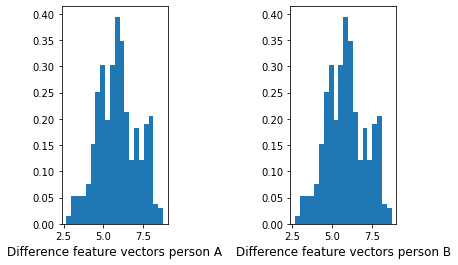

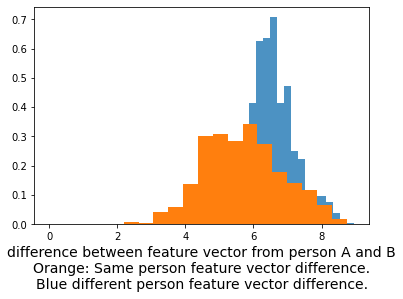


average difference between the same person :  5.686558252645127
average difference between different person:  6.56124202627285


In [0]:
# Left top plot: Compared images of person A with itself using euclidean distance
# right top plot: Compared images of person B with itself using euclidean distance
plt.subplot(1, 2, 1)
plt.hist(kat_sim, bins=20, density=True)
plt.xlabel("Difference feature vectors person A", fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(hart_sim, bins=20, density=True)
plt.xlabel("Difference feature vectors person B", fontsize=12)
plt.subplots_adjust(hspace=0.00, wspace=1.15)
plt.show()

# Bottom plot: Orange = distance of comparing person A with A or B with B
#              Blue   = Comparing person A with B <- As we can see the distance is larger.
plt.hist(diff, bins=20, density=True, alpha=0.8)
plt.hist(sim, bins=20, density=True)
text = "difference between feature vector from person A and B\nOrange: Same person feature vector difference.\nBlue different person feature vector difference."
plt.xlabel(text, fontsize=14)
plt.show()

print("\naverage difference between the same person : ", np.average(sim))
print("average difference between different person: ", np.average(diff))

**2.1 Match Score - Scikit**

As we can see, the feature vector from the same person is smaller than the feature vector of comparing two different people. There are overlappings but theses will not give any problem with the usage of a K-NN classifier for finding the right class.

The difference is around 1.1 when having the match the different feature vectors. (This distance will be increased in 5.3 (Impress your TA's))

In [0]:
from skimage.feature import hog
from skimage import exposure

image = faces[0]
img_indexes = range(0,80)
features_sci = []
hog_images = []

for i in img_indexes : 
  fd, hog_image = hog(faces[i], orientations=9, pixels_per_cell=(10, 10),
                      cells_per_block=(4, 4), visualize=True, transform_sqrt=True,
                      feature_vector=True)
  features_sci.append(fd)
  hog_images.append(hog_image)
plt.show()

sim = []
diff = []
for i in range((len(kat) + len(hart))):
  for j in range((len(kat) + len(hart))):
    if i != j:
      # euclidean distance
      eucl = np.linalg.norm(features_sci[i]- features_sci[j])
      if target[i] == target[j]:
        sim.append(eucl)
      else:
        diff.append(eucl)
      


**2.2 Match score - Scikit**

The euclidean distance between all comparisons are decreased. But the shape of the distances are similar compared to the HOG calculation of OpenCV. 

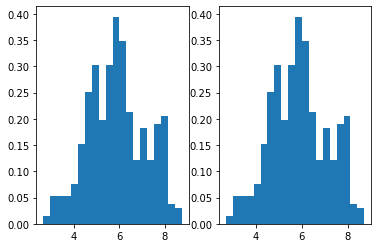

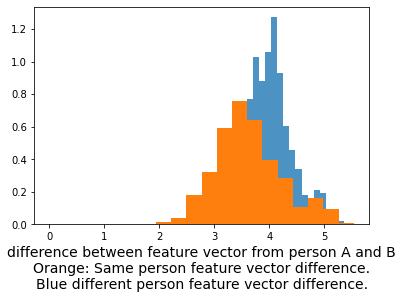

3.622463783295155
4.058053334276783


In [0]:
kat_sim = calc_sim_distance(kat)
hart_sim = calc_sim_distance(hart)

# Left top plot: Compared images of person A with itself using euclidean distance
# right top plot: Compared images of person B with itself using euclidean distance
plt.subplot(1, 2, 1)
plt.hist(kat_sim, bins=20, density=True)

plt.subplot(1, 2, 2)
plt.hist(hart_sim, bins=20, density=True)
plt.show()

# Bottom plot: Orange = distance of comparing person A with A or B with B
#              Blue   = Comparing person A with B <- As we can see the distance is larger.
plt.hist(diff, bins=20, density=True, alpha=0.8)
plt.hist(sim, bins=20, density=True)
text = "difference between feature vector from person A and B\nOrange: Same person feature vector difference.\nBlue different person feature vector difference."
plt.xlabel(text, fontsize=14)
plt.show()

print(np.average(sim))
print(np.average(diff))

**2.3 HOG Visualization**

Visualization of HOG-image with Scitkit-Learn. The directions of the gradients makes the shape of the person visible. 

The implementation of the **HOG-feature** with **Scikit-Learn** does **not** make any **difference** at all. (this can be seen on the generated histogram above when compared to the histogram of the HOG-feature with OpenCV). Because we can make use more parameters with **OpenCV** we will use that one in the **classification/identification** part. (it also follow the original HOG paper)

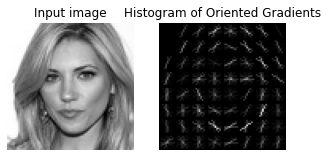

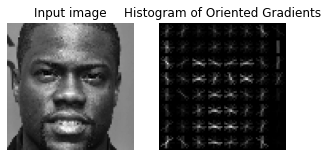

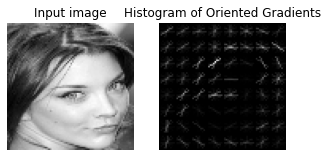

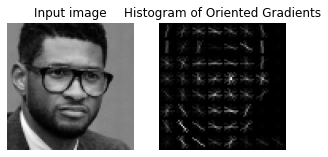

In [0]:
idxs = [1, 32, 60, 70]
for i in idxs:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4), sharex=True, sharey=True)
  img = faces[i]

  ax1.axis('off')
  ax1.imshow(img, cmap=plt.cm.gray)
  ax1.set_title('Input image')

  # Rescale histogram for better display
  hog_image_rescaled = exposure.rescale_intensity(hog_images[i], in_range=(0, 10))

  ax2.axis('off')
  ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
  ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## **5. Exploit feature representations (HOG)**



### 5.1 Classification (HOG)

K-NN is used for classification. The reason for this is it's simplicity, robustness to outliers and because the training data is already labeled which will make it easy for classification in our case.

The data is split evenly between person A and B with 10 test and 20train images. Shuffling is disabled for the purpose of reproducability.

For the test images of **person A** and **B** we get for **K = 3** a score of **95%**. The K-NN classifier makes some small mistakes.



In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import random

# Create test,train data for person A (random)
x_train_A, x_test_A, y_train_A, y_test_A = train_test_split(features[0:30], target[0:30], test_size=0.33, shuffle=False)

# Create test,train data for person B (random)
x_train_B, x_test_B, y_train_B, y_test_B = train_test_split(features[30:60], target[30:60], test_size=0.33, shuffle=False)

# Merge test, train data from person A and B
x_train_data = np.vstack((x_train_A, x_train_B))
y_train_data = np.hstack((y_train_A, y_train_B))

NN = KNeighborsClassifier(n_neighbors=3).fit(x_train_data, y_train_data)

x_test_data = np.vstack((x_test_A, x_test_B))
y_test_data = np.hstack((y_test_A, y_test_B))

score = NN.score(x_test_data, y_test_data)
print('3-NN classifier accuracy:  %2.1f%%' % (score * 100))

3-NN classifier accuracy:  95.0%


Prediction results on person C and D. 

**Green Label** means that the classifier worked **correct**. 

**Red** is classified **wrong**.

`Class 0`: person A and C

`Class 1`: person B and D

As we can see the identication made some mistakes, only for person D (Usher Raymond). The mistakes are for example a person wearing some glasses or the image containing some (blond) hair. 

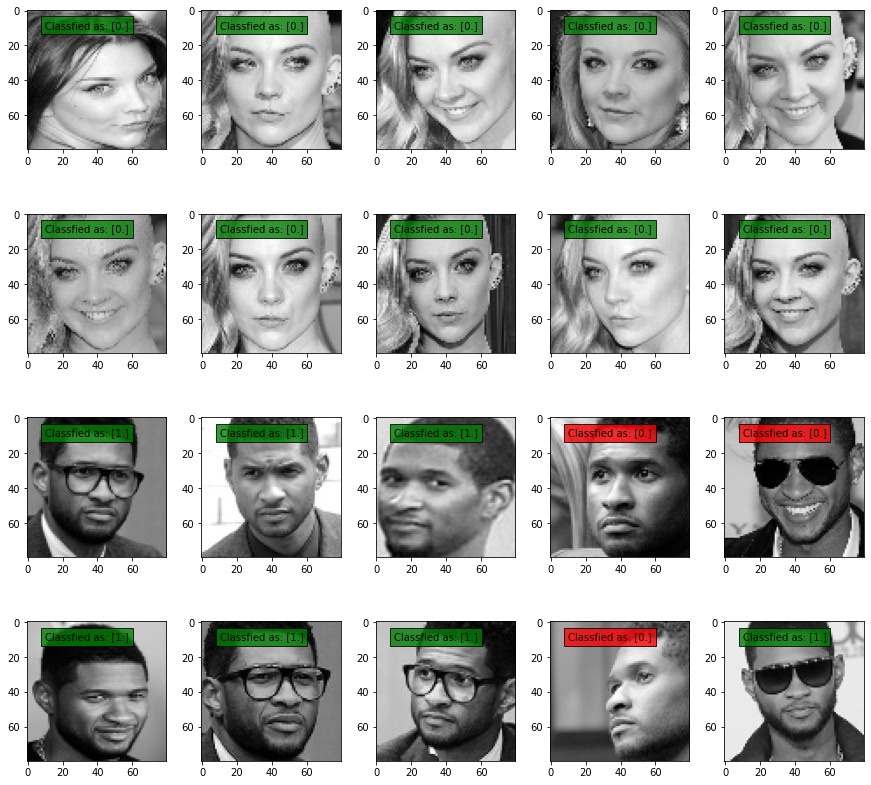

In [0]:
def plot_clf():
  # Prediction on person C and D
  pred_C_D = []

  for i in range(60,80):
    pred_C_D.append(NN.predict([features[i]]))

  C_D = faces[60:80]

  sz = faces[0].shape
  data = np.zeros((len(C_D), sz[0] * sz[1]), dtype=np.uint8)
  for i in range(len(C_D)):
      data[i, :] = C_D[i].flatten()
  f, axs = plt.subplots(4,5, figsize=(15,15))
  plt.subplots_adjust(hspace=0.00, wspace=0.25)

  for i in range(4):
      for j in range(5):
          axs[i,j].imshow(C_D[i*5+j], cmap=plt.cm.gray)
          text = "Classfied as: " + str(pred_C_D[i*5+j])
          if pred_C_D[i*5 + j] == target[60+(i*5+j)]:
            axs[i,j].text(10, 10, text, bbox=dict(facecolor='green', alpha=0.8))
          else:
            axs[i,j].text(10, 10, text, bbox=dict(facecolor='red', alpha=0.8)) 

plot_clf()

### 5.2 Identification (HOG)

Data Space representation using (t-SNE) - Contrary to PCA it is not a mathematical technique but a probablistic one which makes the prediction results vary a lot.

When using 2 components for the visualization it is clearly distinguisable between the two classes (0 and 1). There are a couple of outliers in the extreme case However when trying to predict the classes from the test set, the accuracy is poor and varies between 30% and 70%. This is randomly assigned because of t-SNE. One of the reasons why the accuracy is poor is because of the very big feature vector (11664 x 1 vector). 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


3-NN classifier accuracy with TSNE:  55.0%



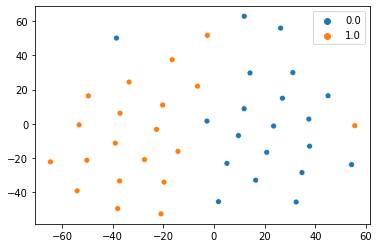

In [0]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

X_embedded  = TSNE(n_components=2).fit_transform(x_train_data)
X_test_embedded  = TSNE(n_components=2).fit_transform(x_test_data)
X_test_CD_embedded  = TSNE(n_components=2).fit_transform(features[60:80])

sns.scatterplot(X_embedded[:,0],
                X_embedded[:,1],
                hue = y_train_data)

neighs_tsne = KNeighborsClassifier(n_neighbors=3)
neighs_tsne.fit(X_embedded, y_train_data)

# run 10 iterations and take the average result of the prediction
total_tp = 0
for j in range(0, 10):
  tp = 0
  for i in range(0, len(X_test_embedded)):
      pred = neighs_tsne.predict([X_test_embedded[i]])
      if pred == y_test_data[i]:
        tp += 1
  total_tp += tp/20

#print("Accuracy of t-sne with 2 components and K = 3: %2.1f%%' % (score * 100)" % (total_tp))
print('3-NN classifier accuracy with TSNE:  %2.1f%%' % (total_tp * 10))
print()



Example of returning the three most-similar images. For K-Nearest Neighbour algorithm of **KNN** (where **K = 3**). This makes it possible to get the most similar images for a specific test image. 

The **first image** is the image in the **test set**. The **following three images** in the same row are the **three most similar pictures** to the testing image.

The identification for person A and C did perform correctly when using **K=3**. As we can see on the results below, there are some mismatches with the most-similar matches, but when using KNN the right label will be chosen for the particular person. However for person B and D the identifcation was completely wrong.  Dependending on the run of TSNE, the results changes every time.

T-sne did perform really bad for the HOG-feature in a 2D space. 

**Note:** The result of the identification strongly depends on the accuracy result of the previous cell. The explanation is based on an accuracy of 45%.

Identification of person A


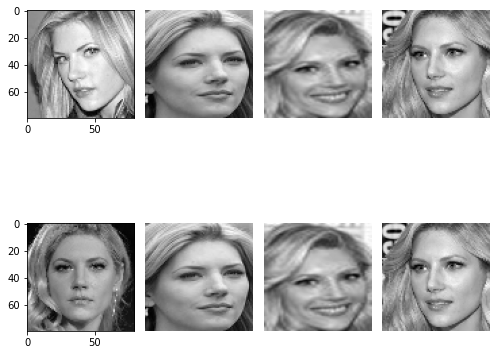

Identification of person B


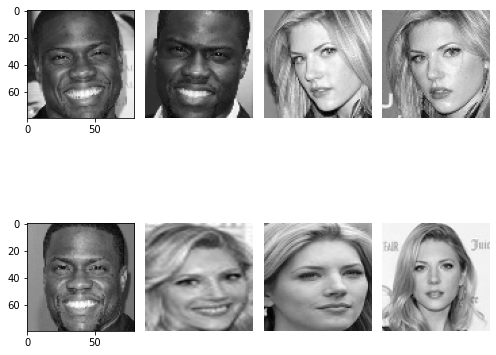

Identification of person C and D


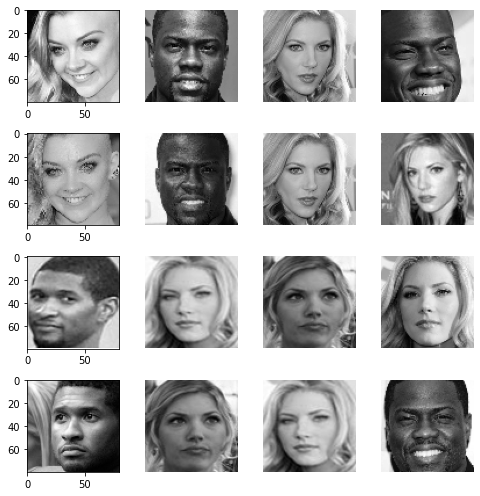

In [0]:
from sklearn.neighbors import NearestNeighbors
import numpy as np



def plot_look_alike_imgs(imgs, test_set_embedded, margin,txt):
  print("Identification of person {}".format(txt))
  n = len(imgs)
  distance, indices = neighs_tsne.kneighbors(test_set_embedded)
  _, axarr = plt.subplots(n, 4, figsize=(7, 7))
  for  idx, j in enumerate(imgs):
    axarr[idx,0].imshow(faces[margin + j], cmap=plt.cm.gray)
    for i in range(1, 4):
      axarr[idx,i].imshow(faces[indices[j][i-1]], cmap=plt.cm.gray)
      axarr[idx,i].axis('off')
  plt.tight_layout()
  
  plt.show()
  

plot_look_alike_imgs([1, 7], X_test_embedded, 20, "A")
plot_look_alike_imgs([11, 17], X_test_embedded, 40, "B")
plot_look_alike_imgs([2, 5, 12, 13], X_test_CD_embedded, 60, "C and D")


### 5.3 Impress your TA’s (HOG)

***Improvement for the HOG-feature classifier/identifier.***

The implementation of the HOG-feature above took the value (40, 40). If we modify this value to (80, 80) the results of classification and identification will increase. The reason for this is that a **larger block size** value will make **local changes less signifcant** and some images posed a problem for this.

If we now again run the **3-NN classifier**, the accuracy of the classifier will increase to **100\%** for the test set of person A and B. Also the **classification** of person **C** and **D** will **increase to 100%**. With the old paramater, three images were classified wrong. Now all of them are labeled correct. From this fact we can also derive that the average distance between person A and B is increased.

For example, if we want to break the classifier and if we used the old implementation of the HOG-feature, it is very easy to do. If the pictures contain some long hair and very dark glasses, the classification does not give the wanted results. This can be verified in part 5.1.1 .

3-NN classifier accuracy:  100.0%


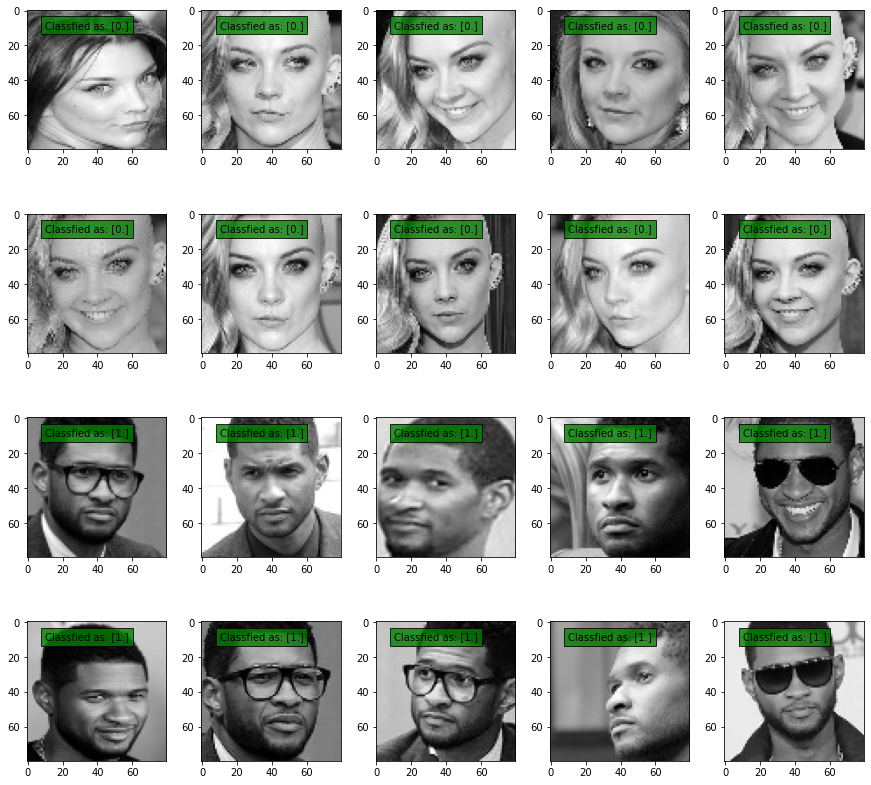

In [0]:
features = np.zeros((len(faces), 5184))

calculate_hog(winSize = (80,80),
              blockSize = (80, 80),
              blockStride = (20, 20),
              cellSize = (10, 10))

# Create test,train data for person A (random)
x_train_A, x_test_A, y_train_A, y_test_A = train_test_split(features[0:30], target[0:30], test_size=0.33, shuffle=False)

# Create test,train data for person B (random)
x_train_B, x_test_B, y_train_B, y_test_B = train_test_split(features[30:60], target[30:60], test_size=0.33, shuffle=False)

# Merge test, train data from person A and B
x_train_data = np.vstack((x_train_A, x_train_B))
y_train_data = np.hstack((y_train_A, y_train_B))

NN = KNeighborsClassifier(n_neighbors=3).fit(x_train_data, y_train_data)

x_test_data = np.vstack((x_test_A, x_test_B))
y_test_data = np.hstack((y_test_A, y_test_B))

score = NN.score(x_test_data, y_test_data)
print('3-NN classifier accuracy:  %2.1f%%' % (score * 100))

plot_clf()

## **4.2 Learning features from data**

##**4.2.1 PCA**

**1. Prepare PCA dataset**

Image is converted to a 2D matrix with shape: n_samples, n_pixels. 
The dimensionality is the number of pixels (6400), sample size is the number of images.

In [0]:
pca_dataset = np.asarray(faces).reshape(len(faces),-1)
train_ab = np.vstack((pca_dataset[0:20,:],pca_dataset[30:50,:]))
test_ab = np.vstack((pca_dataset[20:30,:],pca_dataset[50:60,:]))
test_cd = np.vstack((pca_dataset[60:80,:]))

Mean is substracted. Notice that data from testing set is substracted by mean of training set.

In [0]:
mean_ab = np.mean(train_ab,axis=0)
train_ab_norm = (train_ab - mean_ab).T
test_ab_norm = (test_ab - mean_ab).T
test_cd_norm = (test_cd - mean_ab).T

Standardization is tried, but the result of classification and idendification does not improve. Since the scale of each dimension are the similar, it is reasonable that standardization does not help.

In [0]:
std_ab = np.std(train_ab,0)
train_ab_std = ((train_ab - mean_ab)/std_ab).T
test_ab_std = ((test_ab - mean_ab)/std_ab).T
test_cd_std = ((test_cd - mean_ab)/std_ab).T

**2. Eigenvalue decomposition**

In [0]:
def eigenDecomp(dataset):
  # Covariance matirx
  cov = np.cov(dataset)
  # Get eigenvalues and unit "length" eigenvectors
  [envals,envecs] = np.linalg.eig(cov)
  # Sort eigenvalues and corresponding eigenvectors in descending order
  idx = np.argsort(-envals)
  return envals[idx],envecs[:,idx]

Eigenvalue decomposition is equivalent to singular value decomposition in this case. Although singular value decomposition is more efficent in computation time, eigenvalue decompostion is still fine given that dataset is not too large.

In [0]:
envals, envecs = eigenDecomp(train_ab_norm)

**3. Visualize reconstruction of one face in training set using gradually more eigenfaces**

In [0]:
def reconstruct(eigenvectors,number_pcs,dataset,dataset_mean):
  e_vecs = eigenvectors[:,range(number_pcs)].real
  proj = np.dot(e_vecs.T,dataset)
  reconstruction_face = np.dot(e_vecs,proj).T + dataset_mean
  return reconstruction_face

*3.1 Person A: First image face*

Text(0.5, 1.0, 'Original Face')

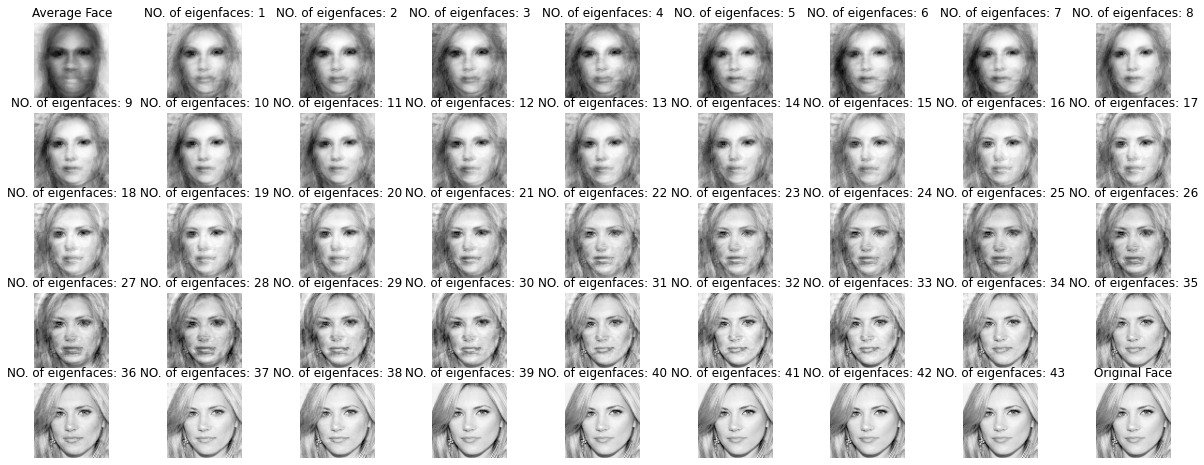

In [0]:
fig = plt.figure(figsize=(21, 8))
# average face
fig.add_subplot(5,9,1)
plt.imshow(mean_ab.reshape(80,-1),cmap = "Greys_r")
plt.title("Average Face")
plt.axis('off')
i = 2
for n in range(1,44):
    r = reconstruct(envecs,n,train_ab_norm,mean_ab)
    oneimage = r[0,:].reshape(80,-1)

    fig.add_subplot(5, 9, i)
    plt.imshow(oneimage,cmap='Greys_r')
    plt.axis('off')
    plt.title("NO. of eigenfaces: %d" % n)
    i += 1
fig.add_subplot(5,9,i)
plt.imshow(train_ab[0,:].reshape(80,-1), cmap='Greys_r')
plt.axis('off')
plt.title("Original Face")

*Person B: First image face*

Text(0.5, 1.0, 'Original Face')

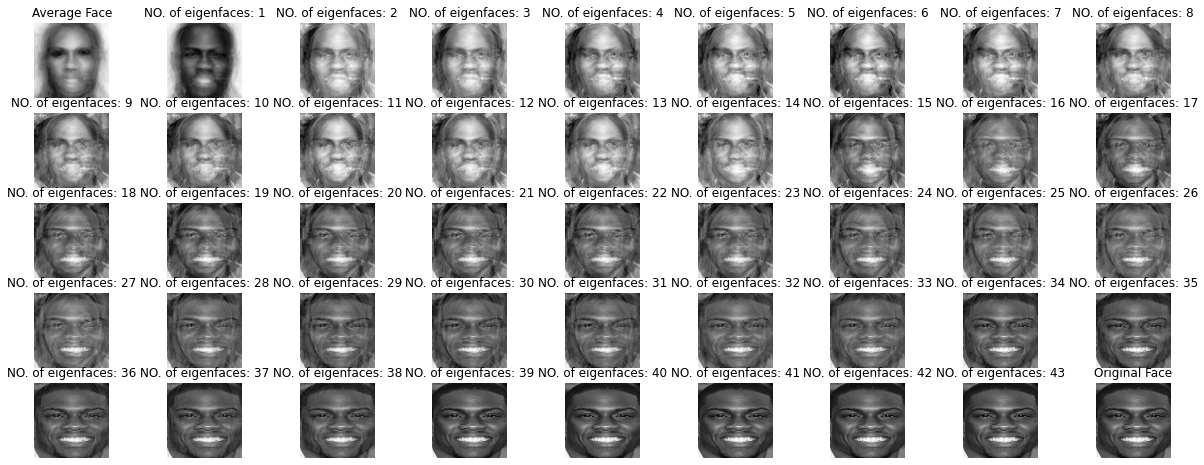

In [0]:
fig = plt.figure(figsize=(21, 8))
# average face
fig.add_subplot(5,9,1)
plt.imshow(mean_ab.reshape(80,-1),cmap = "Greys_r")
plt.title("Average Face")
plt.axis('off')
i = 2
for n in range(1,44):
    r = reconstruct(envecs,n,train_ab_norm,mean_ab)
    oneimage = r[20,:].reshape(80,-1)

    fig.add_subplot(5, 9, i)
    plt.imshow(oneimage,cmap='Greys_r')
    plt.axis('off')
    plt.title("NO. of eigenfaces: %d" % n)
    i += 1
fig.add_subplot(5,9,i)
plt.imshow(train_ab[20,:].reshape(80,-1), cmap='Greys_r')
plt.axis('off')
plt.title("Original Face")

**4. Choose the optimal number p of principal components**

In [0]:
# Scree plot
def screeplot(eigenvalues,pc_number):
  list_eigenvalue = []
  for n in range(0,pc_number):
      e_vals = eigenvalues[n]
      list_eigenvalue.append(e_vals)
  fig = plt.figure(figsize=(10, 4))
  plt.plot(range(1,pc_number+1),np.real(list_eigenvalue),'b',label="Eigenvalue")
  plt.xticks(np.arange(0,pc_number+1))
  plt.grid(axis='x',linestyle='-.')
  plt.legend(loc="center right")
  plt.ylabel("Eigenvalue")
  plt.xlabel("Component number")
  plt.title("Figure1-1 Scree Plot")
  plt.show()

# Percentage of variance accounted for (accumulated)
def accumulated(eigenvalues,number_pcs):
  e_vals = eigenvalues[:number_pcs]
  percent = np.cumsum(e_vals)/sum(eigenvalues)
  fig = plt.figure(figsize=(10, 4))
  plt.plot(range(1,number_pcs+1),np.real(percent),'b', label="Percent of Variance Captured")
  plt.axhline(y=0.8, color='m', linestyle='--')
  plt.legend(loc="center right")
  plt.xticks(np.arange(0,number_pcs+1))
  plt.grid(axis='x',linestyle='-.')
  plt.ylabel("Accumulated Percentage")
  plt.xlabel("Number of Principal Components")
  plt.title("Figure1-2 Accumlated Percentage of variance accounted")
  plt.show()

# MSE plot
def mse(reconstruction,original):
  error = original - reconstruction
  squared = error*error
  loss = squared.sum(1).mean()
  return loss

def mseplot(eigenvector,dataset,dataset_mean,dataset_original,number_pcs):
  list_mse = []
  for n in range(0,number_pcs+1):
    r = reconstruct(eigenvector,n,dataset,dataset_mean) 
    loss = mse(r,dataset_original)
    list_mse.append(loss)
  fig = plt.figure(figsize=(10, 4))
  plt.plot(range(0,number_pcs+1),list_mse,'r', label="MSE of Reconstruction from Original")
  plt.legend(loc="center right")
  plt.xticks(np.arange(0,number_pcs+1))
  plt.grid(axis='x',linestyle='-.')
  plt.ylabel("Mean Squared error")
  plt.xlabel("Number of Principal Components")
  plt.title("Figure1-3 Average construction loss")
  plt.show()

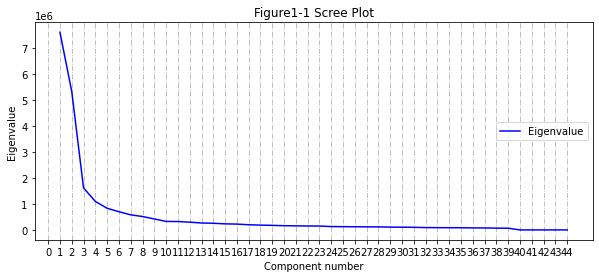

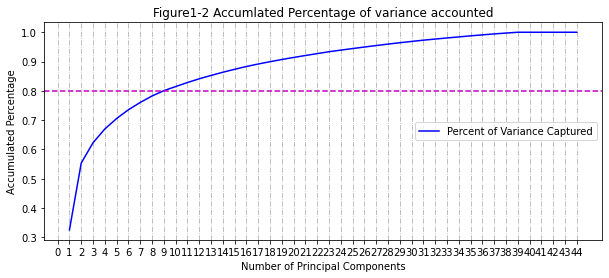

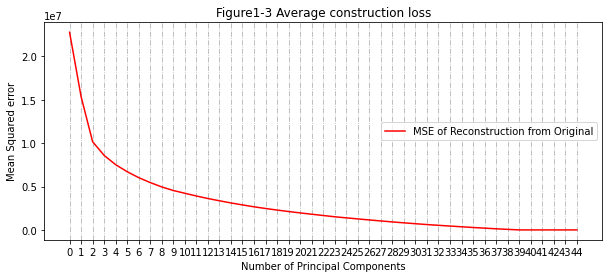

In [0]:
screeplot(envals,44)
accumulated(envals,44)
mseplot(envecs,train_ab_norm,mean_ab,train_ab,44)

According to the Scree plot (Figure 1-1) and percentage plot (Figure 1-2), we find that the first 39 principle components explained nearly 100% of the total variance and had eigenvalues much larger than 1. However, average construction loss plot (Figure 1-3) shows that mean squared error for 39 principal components in training set is nearly zero. It may have overfitting problem. 

According to the Scree plot, the first nine components might be appropriate. Because starting from the 10th component, the plot becomes flat. Also, first nine compents can explain nearly 80% total variance. Average construction loss plot (Figure 1-3) also shows that mean squared error for 9 components in training set is not that large. However, the selection of principal compnents needs further analysis combined with eignfaces.

**5. Visualize the faces in the principal component space**

In [0]:
def eigenface(eigenvector,number_pcs):
  e_vecs = eigenvector[:,range(number_pcs)].real
  fig = plt.figure(figsize=(15, 10))
  for n in range(0,number_pcs):
    e_faces = e_vecs[:,n].reshape(80,-1)
    fig.add_subplot(5, 8, n+1)
    plt.imshow(e_faces,cmap='Greys_r')
    plt.axis('off')
    plt.title("Eignface "+str(n+1))

Eigenfaces are visualized as below.

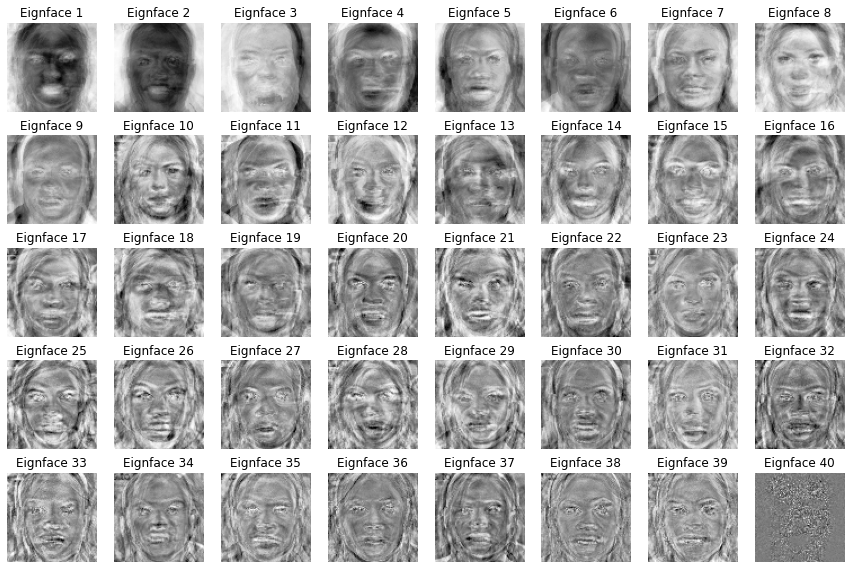

In [0]:
eigenface(envecs,40)

Eigenface also indicates that 9 principle components might be suitable, which capture some charateristics of faces.

In addition, the first two eigenfaces caputure the black skin color and white teeth. Especially, the strong contrast between skin and teeth is captured by the first eigenface. 



**6. Test PCA**

Project the test images onto to the same 9 components trainined from training set.

In [0]:
vecs = envecs[:,range(9)].real
proj = np.dot(vecs.T,test_ab_norm)

Plot test set on the first two principal components space.

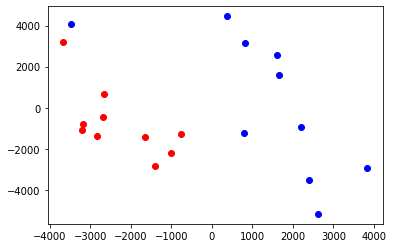

In [0]:
# Scatter plot
for n in range(0,10):
  scatter = plt.scatter(proj[0,n],proj[1,n],color = "r")
for n in range(10,20):
  scatter = plt.scatter(proj[0,n],proj[1,n],color = "b")

Scatter plot of test set with preson A in Red and person B in Blue. In the first two components space, one image for person B is obviously closer to the cluster of person A.

Next, visualize the new faces on a face-feature plot of the first two principal components.

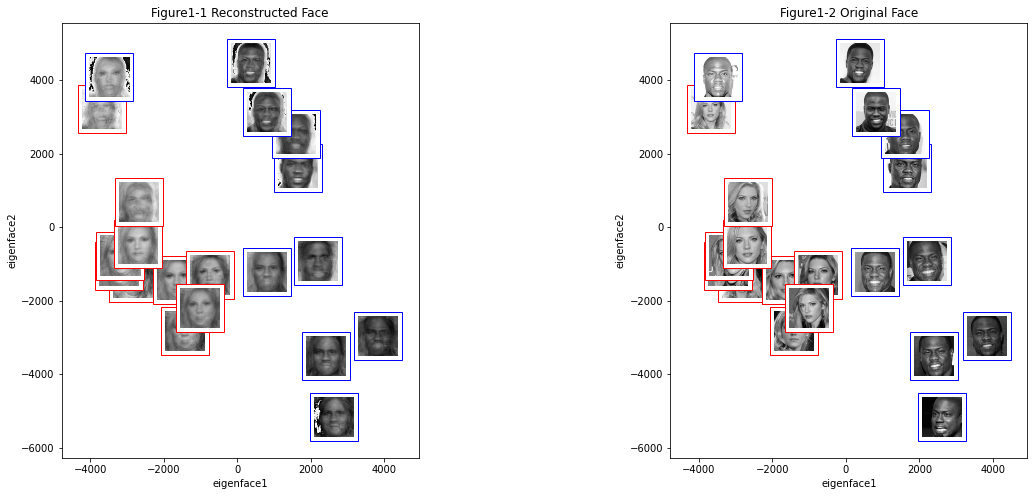

In [0]:
# Reconstructing original images from the 39 components
r_test = reconstruct(envecs,9,test_ab_norm,mean_ab)

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
testlabel = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fig = plt.gcf()
fig.set_size_inches(20,8, forward=True)
fig.clf()
ax1 = plt.subplot(121)
ax1.set_xlim(min(proj[0, :]) - 1100, max(proj[0, :]) + 1100)
ax1.set_ylim(min(proj[1, :]) - 1100, max(proj[1, :]) + 1100)
ax1.set(xlabel='eigenface1',ylabel='eigenface2',title = "Figure1-1 Reconstructed Face")
ax1.set_aspect(1.0)
for i in range(20):
    imagebox = OffsetImage(cv2.cvtColor(r_test[i,:].reshape(80,-1).astype(np.uint8), cv2.COLOR_GRAY2RGB), zoom=.5)
    xy = [proj[0,i], proj[1,i]]
    if testlabel[i] == 1:
        ab = AnnotationBbox(imagebox, xy, frameon=True, bboxprops=dict(edgecolor='red'))
    else:
        ab = AnnotationBbox(imagebox, xy, frameon=True, bboxprops=dict(edgecolor='blue'))
    ax1.add_artist(ab)

ax2 = plt.subplot(122)
ax2.set_xlim(min(proj[0, :]) - 1100, max(proj[0, :]) + 1100)
ax2.set_ylim(min(proj[1, :]) - 1100, max(proj[1, :]) + 1100)
ax2.set(xlabel='eigenface1',ylabel='eigenface2',title = "Figure1-2 Original Face")
ax2.set_aspect(1.0)
for i in range(20):

    imagebox = OffsetImage(cv2.cvtColor(test_ab[i,:].reshape(80,-1).astype(np.uint8), cv2.COLOR_GRAY2RGB), zoom=.5)
    xy = [proj[0,i], proj[1,i]]
    if testlabel[i] == 1:
        ab = AnnotationBbox(imagebox, xy, frameon=True, bboxprops=dict(edgecolor='red'))
    else:
        ab = AnnotationBbox(imagebox, xy, frameon=True, bboxprops=dict(edgecolor='blue'))
    ax2.add_artist(ab)

The reconstrued test images are visualized in the face feature plot (Figure1-1) and original test images are visualized in Figure1-2. Person A is in red and Person B is in blue.

It clearly shows that person A and person B are well separated by the first two components, except for one image for person B (top left). This image has a much brighter skin color than other images for person B. Besides, as mentioned before, the first two eigenfaces in the previous section caputure the strong constrast between color of skin and teeth, while this image does not show this charateristic, which might be the reason of misclassification.

By comparing reconstructed face and original face in Figure1-1 and Figure1-2. Most of the faces are constructed well, except for some rotated faces.  

**7. Build PCA feature representations**

In [0]:
def pcafeature(eigenvector, dataset_norm, num_pcs):
  envecs = eigenvector[:,range(num_pcs)].real
  proj = np.dot(envecs.T,dataset_norm)
  data_pca_x = proj
  return data_pca_x

PCA feature representations are built according to nine principal compents trained before.

`Class 0`: person A and C

`Class 1`: person B and D


In [0]:
num_pcs = 9
training_ab_x = pcafeature(envecs,train_ab_norm,num_pcs).T
testing_ab_x = pcafeature(envecs,test_ab_norm,num_pcs).T
testing_cd_x = pcafeature(envecs,test_cd_norm,num_pcs).T
training_ab_y = np.hstack((np.zeros(20),np.ones(20)))
testing_ab_y = np.hstack((np.zeros(10),np.ones(10)))
testing_cd_y = np.hstack((np.zeros(10),np.ones(10)))

# Target labels for person A, B, C, D
target_label_A = np.zeros(10)
target_label_B = np.ones(10)
target_label_C = np.zeros(10)
target_label_D = np.ones(10)

# Create target labels (0 for person A, 1 for person B)
target = np.concatenate((target_label_A, target_label_B, target_label_C, target_label_D))

## **5. Exploit feature representations (PCA)**

###5.1 Classification (PCA)

In [0]:
def plot_classfication(original_image,index,label_predict):
  sz = faces[0].shape
  data = np.zeros((len(original_image), sz[0] * sz[1]), dtype=np.uint8)
  for i in range(len(original_image)):
      data[i, :] = original_image[i].flatten()
  f, axs = plt.subplots(4,5, figsize=(10,10))
  plt.subplots_adjust(hspace=0.00, wspace=0.25)

  for i in range(4):
      for j in range(5):
          axs[i,j].imshow(original_image[i*5+j], cmap=plt.cm.gray)
          text = "Classfied as: " + str(label_predict[i*5+j])
          if label_predict[i*5 + j] == target[index+(i*5+j)]:
            axs[i,j].text(10, 10, text, bbox=dict(facecolor='green', alpha=0.8))
          else:
            axs[i,j].text(10, 10, text, bbox=dict(facecolor='red', alpha=0.8)) 

**Classification using Random Forests**

Considering the number of features are nine considering sample size of dataset is 60. Generalize linear regression might have problem in high dimensions. Thus, ensemble model random forests are conducted.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=200,bootstrap = True,max_features = 'sqrt')
# Train the model on training data
rf.fit(training_ab_x, training_ab_y)
# Use the forest's predict method on the test data
predict_ab_rf = rf.predict(testing_ab_x)
predict_cd_rf = rf.predict(testing_cd_x)
print(classification_report(testing_ab_y,predict_ab_rf))
print(classification_report(testing_cd_y,predict_cd_rf))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



The accuracy for testing_ab is 0.95 and for testing_cd is 0.85.

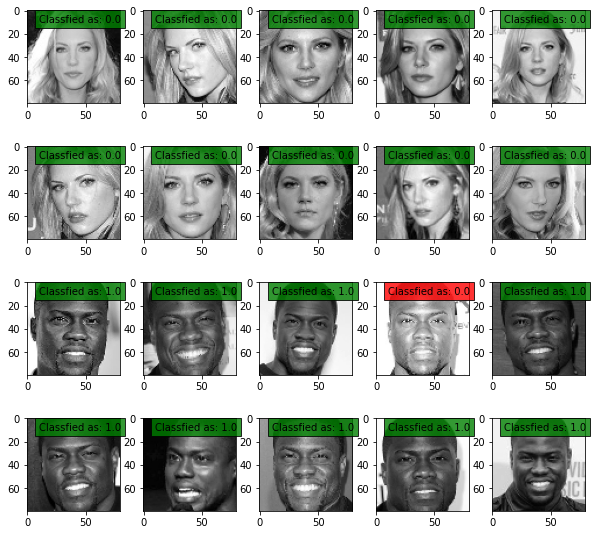

In [0]:
plot_classfication(faces[20:30]+faces[50:60],0,predict_ab_rf)

In the testing set of ab, there are one images for person B are misclassified as person A. This face image is the same as the misclassified one in the face feature plot.

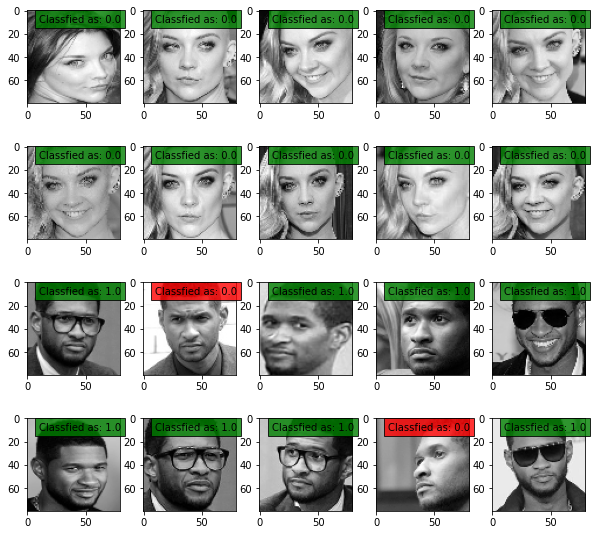

In [0]:
plot_classfication(faces[60:80],20,predict_cd_rf)

In the testing set of cd, there are three images for person D are misclassified as person A. The reason might be that the characteristic of skin and teeth are not apparent. In addition, glasses do not affect the classifier. 

###**5.2 Identification (PCA)**

In the high dimension, data is distributed sparsely and euclidean distances does not work well in KNN. In addition, in the first two principal components scatter plot as shown before, the two classes are separated. The eigenvalue for the third principal components are still high. Therefore, feature representation of every image is calculated based on the first three principal components trained before. 

In [0]:
num_pcs = 3
training_ab_x = pcafeature(envecs,train_ab_norm,num_pcs).T
testing_ab_x = pcafeature(envecs,test_ab_norm,num_pcs).T
testing_cd_x = pcafeature(envecs,test_cd_norm,num_pcs).T
training_ab_y = np.hstack((np.zeros(20),np.ones(20)))
testing_ab_y = np.hstack((np.zeros(10),np.ones(10)))
testing_cd_y = np.hstack((np.zeros(10),np.ones(10)))

# Target labels for person A, B, C, D
target_label_A = np.zeros(10)
target_label_B = np.ones(10)
target_label_C = np.zeros(10)
target_label_D = np.ones(10)

# Create target labels (0 for person A, 1 for person B)
target = np.concatenate((target_label_A, target_label_B, target_label_C, target_label_D))

Try with different K, K = 3 gives us a better accuracy in testing set.

In [0]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(training_ab_x, training_ab_y)

predict_ab_knn = classifier.predict(testing_ab_x)
predict_cd_knn = classifier.predict(testing_cd_x)

print(predict_ab_knn)
print(predict_cd_knn)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]


Not all identification of person A and person B successful for all descriptors.

In the testing_ab, one image for person B is labeled as person A.

In the testing_cd, two images for peron D are labeled as person A.

Next, the mislabeled picture and first three closest pictures in the training set are shown as below.

In [0]:
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(training_ab_x)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [0]:
def plot_closest(mislabel_x,original_pic,train_pic):
  distance,index = neigh.kneighbors([mislabel_x])
  fig = plt.figure(figsize=(8, 4))
  fig.add_subplot(1, 4, 1)
  plt.imshow(original_pic.reshape(80,-1),cmap='Greys_r')
  plt.title("Labeled Face")
  fig.add_subplot(1, 4, 2)
  plt.imshow(train_pic[index[0][0]].reshape(80,-1),cmap='Greys_r')
  plt.title("1st closest")
  fig.add_subplot(1, 4, 3)
  plt.imshow(train_pic[index[0][1]].reshape(80,-1),cmap='Greys_r')
  plt.title("2nd closest")
  fig.add_subplot(1, 4, 4)
  plt.imshow(train_pic[index[0][2]].reshape(80,-1),cmap='Greys_r')
  plt.title("3rd closest")
  print("Index in training set:",index)

**Person B mislabeled as Person A**

Index in training set: [[16  3  1]]


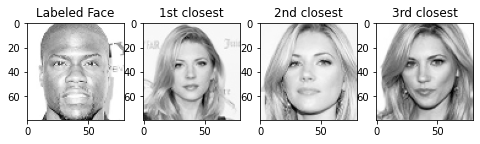

In [0]:
plot_closest(testing_ab_x[13],test_ab[13],train_ab)

**Person C mislabeled as Person A**

Index in training set: [[13  4 19]]
Index in training set: [[ 8 19 14]]


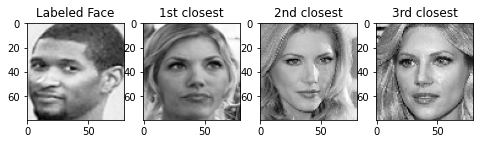

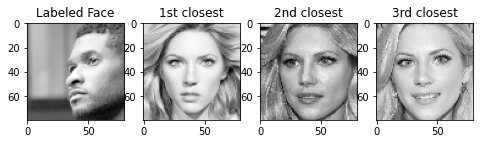

In [0]:
plot_closest(testing_cd_x[12],test_cd[12],train_ab)
plot_closest(testing_cd_x[18],test_cd[18],train_ab)

All images for Person A and Person C are labeled correctly as Person A. Some examples are shown. 

Index in training set: [[11  9  8]]
Index in training set: [[12  0 15]]


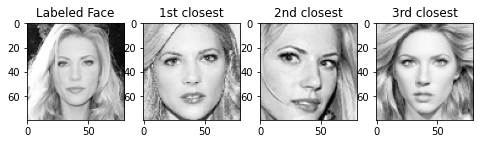

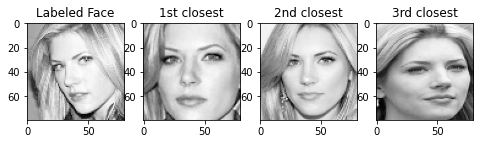

In [0]:
plot_closest(testing_ab_x[0],test_ab[0],train_ab)
plot_closest(testing_ab_x[1],test_ab[1],train_ab)

Index in training set: [[19  5 15]]
Index in training set: [[12 15 14]]


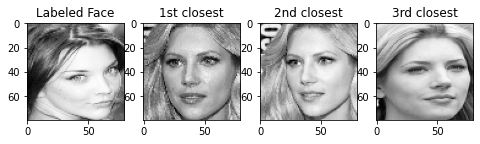

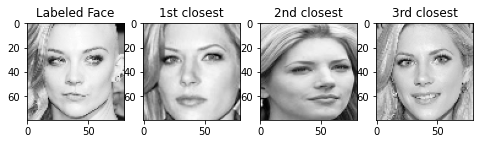

In [0]:
plot_closest(testing_cd_x[0],test_cd[0],train_ab)
plot_closest(testing_cd_x[1],test_cd[1],train_ab)

Some examples related to correct labelling for Person B and Person D 
are shown.

Index in training set: [[39 34 26]]
Index in training set: [[23 21 33]]


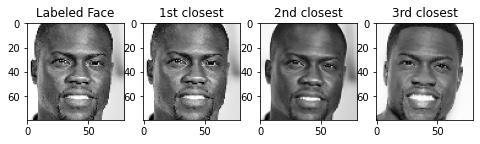

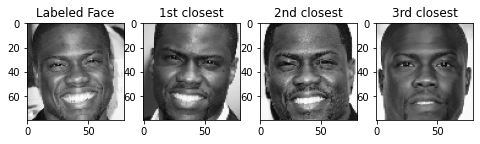

In [0]:
plot_closest(testing_ab_x[10],test_ab[10],train_ab)
plot_closest(testing_ab_x[11],test_ab[11],train_ab)

Index in training set: [[23 22 21]]
Index in training set: [[ 1 30 37]]


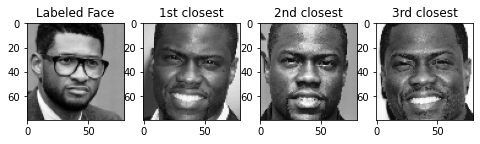

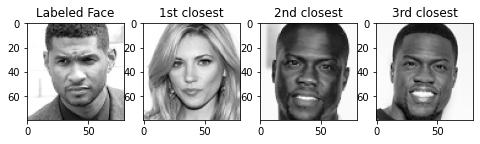

In [0]:
plot_closest(testing_cd_x[10],test_cd[10],train_ab)
plot_closest(testing_cd_x[11],test_cd[11],train_ab)

In this case, clustering based on similarity scores between pairs of data examples is powerful, especially after PCA dimensions reduction is conducted. Dimensions are largely reduced and independent, so similarity score will not be influenced by irrelevant dimensions.

## **4.2.2 Transfer Learning**

In [0]:
%tensorflow_version 1.x
#! pip install keras==2.2.4
import keras 
keras.__version__

TensorFlow 1.x selected.


Using TensorFlow backend.


'2.2.5'

In [0]:
#first import the necessary libraries
try:
  from keras_vggface.vggface import VGGFace
except ModuleNotFoundError:
  !pip install keras-vggface
  from keras_vggface.vggface import VGGFace
import tensorflow as tf
from keras_vggface import utils
from sklearn.manifold import TSNE

**1. Preprocessing**

First reload the face pictures in color, change the channels from BGR (which is the OpenCv Channel style) to RGB which is the keras_vggface  chanel order and resize them to 224x224 size

In [0]:
#vgg face needs pictures at size of 224x244x3, therefore we reload them in the
#right size, and the right format, since the cv2 format has a different channel
# order then the scikit image package uses:
org_faces = [img[...,::-1]for img in images__]
org_faces = [cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) for img in org_faces]
org_faces = [f.astype('int') for f in org_faces]

Now preprocess all the Face images to the Tensorflow image format (normalizing them to a range of -1 to +1 from 0 to 255 in the beginninge

In [0]:
faces_tf_preprocessed = [tf.keras.preprocessing.image.img_to_array(img) for img in org_faces]
faces_tf_preprocessed = [np.expand_dims(img, axis=0) for img in faces_tf_preprocessed]

#now we normalize the image values from 0 to 256 to -1 to 1, since tensorflow requires this
faces_tf_preprocessed = [utils.preprocess_input(img, version=1) for img in faces_tf_preprocessed]

#create the target labels
# Target labels for person A, B, C, D
target_label_A = np.zeros(30)
target_label_B = np.ones(30)
target_label_C = np.zeros(10)
target_label_D = np.ones(10)

# Create target labels (0 for person A, 1 for person B)
target = np.concatenate((target_label_A, target_label_B, target_label_C, target_label_D))

#tag all pictures with its celebrities by putting it all together in one dict:
names = target
#now label the data with the 0/1 label for persons A/B/C/D
data = list(zip(names, faces_tf_preprocessed))

now we split up our dataset in train and test set, we also save the original face pictures in train/test_original, so they have the same indexation as the featurevectors and we can show our results later

In [0]:
train = data[0:20]
train.extend(data[30:50])
test = data[20:30]
test.extend(data[50:60])
test.extend(data[60:80])
test_original = org_faces[20:30]
test_original.extend(org_faces[50:60])
test_original.extend(org_faces[60:80])
train_original = org_faces[0:20]
train_original.extend(org_faces[30:50])
#_original will keep the full image for later use, the other list only contain the feature vector of the image later

**2. Load VGG16**

Now lets start to load the pretrained vgg16 model. By include_top=False we remove the classifier, and the model only returns a feature vector with 256 entries we will use later for classification

In [0]:
#start with loading the pretrained knn without the last layer
model_base = VGGFace(include_top=False, model='vgg16', weights='vggface',
              input_shape=(224,224,3), pooling='avg')





58916864/58909280 [==============================] - 3s 0us/step








**3. Extract feature vector**

now we start to get the feature vector by model_base.predict(picture) of all training and test pictures

In [0]:
train = [(dat[0], model_base.predict(dat[1])) for dat in train]
test = [(dat[0], model_base.predict(dat[1])) for dat in test]

Seperate labels and feature values in two different lists for easier visualization

In [0]:
predictions_labels = [dat[0] for dat in train]
predictions = np.asarray([dat[1] for dat in train])

**4. Visualisation**

now do the tsne fitting to project the featurevectors in a 2d dataspace for visualization

In [0]:
predictions = predictions.squeeze() #remove unnecessary dimensions from the array
Projector = TSNE(n_components=2)
TSNE_Fitting = Projector.fit_transform(predictions)

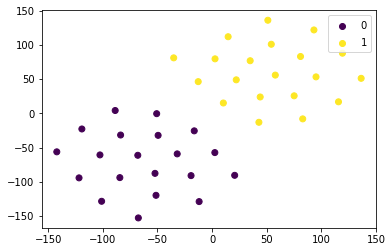

In [0]:
import matplotlib.pyplot as plt
x, y = zip(*TSNE_Fitting)

fig, ax = plt.subplots()
scatter = ax.scatter(x,y,c=predictions_labels)
ax.legend(*scatter.legend_elements())

we can see, that the pictures in the Featurespace are clearly seperatable from each other. But since TSNE is not reproducabel, we can not use it for classificaion, we can only see, that the data is seperable. Lets try to build a classifier by using a support vector machine


## **5. Exploit feature representations (Transfer Learning)**

### 5.1 Classification (Transfer Learning)

Now we build a Support Vector Classfier for a binary classification of the pictures and test in on the test set

In [0]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(predictions, predictions_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

First we test the classifier with the test pictures of Person A and Person B

In [0]:
score = clf.score([t[1].squeeze() for t in test[0:20]], [t[0] for t in test[0:20]])

In [0]:
score

1.0

The score of 1 means, the classifier classifies all the test samples right.
Now  we test how the Classifier works on Person C and D and if they are correctly labled as Person A and B as we want it to be

In [0]:
score_unseen = clf.score([t[1].squeeze() for t in test[20:]], [t[0] for t in test[20:]])

In [0]:
score_unseen

1.0

So, its predicting the unseen persons as expected


### 5.2 Identification (Transfer Learning) 

In [0]:
from sklearn import neighbors
from sklearn.metrics import pairwise_distances as pairwise_distances

Lets start with the most simmilar training pictures of Person A for a given test picture. 

We start to compute the distance between the feature vector of person A testpic 0, and all the training pictures. Then we sort the distances and plot the pictures with the highest simmilaritie (smallest distance) to the test picture.

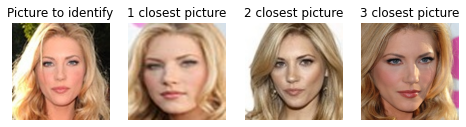

In [0]:
distances = pairwise_distances(predictions, test[0][1])
distances = distances.squeeze()
k = 3 #find the three most simmilar pictures to the pic test[0]
smallest = np.argsort(distances)[0:k] #returns the indices of the k smallest distances, lets plot the pictures

fig, ax = plt.subplots(1,4, figsize=(8,4))
ax[0].axis('off')
ax[0].imshow(test_original[0])
ax[0].set_title('Picture to identify')
for i in range(k):
  ax[i+1].imshow(train_original[smallest[i]])
  ax[i+1].axis('off')
  ax[i+1].set_title(str(i+1) +' closest picture')

That works fine already. The picture on the left is the test picture, the pictures next to it are the most simmilar ones(from high simmilarity to low simmilarity).
Lets do the same with person B:

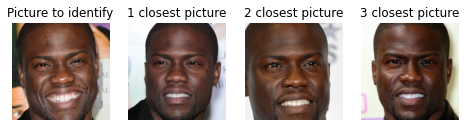

In [0]:
distances = pairwise_distances(predictions, test[11][1])
distances = distances.squeeze()
k = 3 #find the three most simmilar pictures to the pic test[0]
smallest = np.argsort(distances)[0:k] #returns the indices of the k smallest distances, lets plot the pictures

fig, ax = plt.subplots(1,4,figsize=(8,4))
ax[0].axis('off')
ax[0].imshow(test_original[11])
ax[0].set_title('Picture to identify')
for i in range(k):
  ax[i+1].imshow(train_original[smallest[i]])
  ax[i+1].axis('off')
  ax[i+1].set_title(str(i+1) +' closest picture')

That works fine as well, we can see, that all simmilar pictures of person A are also smiling.
Lets check it for Person C now, who is simmilar to her?

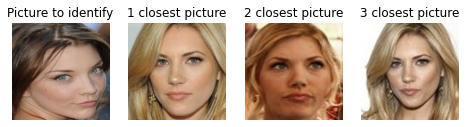

In [0]:
distances = pairwise_distances(predictions, test[20][1])
distances = distances.squeeze()
k = 3 #find the three most simmilar pictures to the pic test[0]
smallest = np.argsort(distances)[0:k] #returns the indices of the k smallest distances, lets plot the pictures

fig, ax = plt.subplots(1,4,figsize=(8,4))
ax[0].axis('off')
ax[0].imshow(test_original[20])
ax[0].set_title('Picture to identify')
for i in range(k):
  ax[i+1].imshow(train_original[smallest[i]])
  ax[i+1].axis('off')
  ax[i+1].set_title(str(i+1) +' closest picture')


lets do the same with Person D

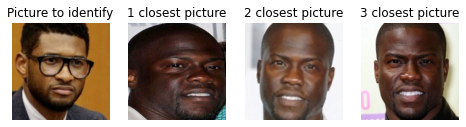

In [0]:
distances = pairwise_distances(predictions, test[30][1])
distances = distances.squeeze()
k = 3 #find the three most simmilar pictures to the pic test[0]
smallest = np.argsort(distances)[0:k] #returns the indices of the k smallest distances, lets plot the pictures

fig, ax = plt.subplots(1,4,figsize=(8,4))
ax[0].imshow(test_original[30])
ax[0].axis('off')
ax[0].set_title('Picture to identify')
for i in range(k):
  ax[i+1].imshow(train_original[smallest[i]])
  ax[i+1].axis('off')
  ax[i+1].set_title(str(i+1) +' closest picture')

# **6. Discussion**



**What did we learn?**

We’ve implemented three different feature representations. The handcrafted features (HF) are quite accurate and about on par with the unsupervised technique, but not as accurate (more detail below) as the one learned from data. HF require no training (in this assignment) and instead calculate the feature vector of each image in a training set. The image is segmented in blocks. In each of these blocks, a ‘Histogram of Gradients’ (HOG) is calculated, wherein the edge’s strength or gradient magnitude (height of the bar), and gradient direction (the bins represent ranges of angles, perpendicular to edge direction) is stored. After normalising by pooling neighbouring blocks, the shape of these histograms can be used to determine the features in particular sections of an image. This information is stored in a feature vector per image. To determine the label (class) of an unseen image, the distance between the image’s feature vector is compared to the vectors of the images is the training set bij calculating the (euclidian) distance between the vectors. Based on the (K) nearest (i.e. most similar) images and their corresponding label, the image is classified. HF could be considered more efficient than classifiers that extract features from data - be it unsupervised or supervised - because they require no resource-expensive training (as we’ll see below, transfer learning doesn’t require training either, as it ‘copies’ previously learned features). Calculating feature vectors requires some computation, but due to the small block size, matrix calculations are relatively modest and significantly less than calculations required for extracting features from data. 

PCA is explored as an unsupervised technique for finding patterns in data of high dimensions. It works by reducing the number of dimensions, but without much loss of information. In our case,  PCA looks for patterns in pixel values that occur in each picture - in a N² x 1-dimensional array (reshaped N x N image array). Each pixel is considered as one dimension. The covariance matrix of the data is decomposed into unit eigenvectors and eigenvalues. The eigenvector is an eigenface which determines the direction of the feature space, while the eigenvalue determines the variance captured by the eigenface. In our case, eigenfaces capture some characteristics of faces, such as black skin, white teeth, hair... The selection of principal components are based on the eigenvalue and mean squared error. After selecting nine principal components, images can be reconstructed based on new feature representations. This new feature representation is also useful to build the classifier because dimensions are largely reduced and redundant information is discarded. 

Transfer learning, the supervised technique used here to extract features learned from data (FD) circumvents the training phase by replacing the last layer in a deep neural network, thus adding a new classification layer to a pre-trained feature extraction network and only requiring training of one (simple) layer. The downside is that you have no control, nor complete understanding of exactly what (type of) features the technique considers when performing its classification task. This is true for all deep networks, but is especially so when using transfer learning. The upside of this technique, however, is that it has been trained on a very large and diverse dataset, leading to a vast set of very accurate feature descriptors. These make for robust classification and identification results. 

**Qualitative differences: classification**

Classification accuracy of all techniques is 85% or above. Top accuracy is achieved by the VGG net, being very robust to attributes such as glasses and hair, as well as different poses (i.e. not exactly frontal) and lighting conditions. 

With HOG, features like glasses or a completely different hair cut (when in the observed area) are very likely to hamper correct classification (this is the case where the block size of the HOG calculations are small). As noted above, HOG is focussed on directions and intensity of gradients in pixel values in order to detect edges. Unexpected edges that are not found in any of the samples of the training set will likely lead to misclassification. The same could be expected for deformations that (locally) change the direction of edges. 

When analysing the results of the PCA analysis, it is concluded that skin tone and white teeth bear most information about the image content. This can be deduced from the face feature plot where one overexposed test image for person B (black male) is positioned closer to person A (white female), than to well exposed pictures of person A. In addition,  this image is misclassified according to random forests used during classification. It’s clear that the first two eigenfaces immediately change the pixel intensity in the facial area from the average value, which captures the characteristic of skin tone. This might explain some misclassifications. PCA gives accuracy of 0.85 on the testing set of person C and person D. All images for person C are correctly classified, while 3 faces for person D are misclassified. The reason might be that the skin tone of Person B and Person D differs slightly, while skin tone is an important feature in PCA feature representation, as mentioned above. Further, PCA feature representation does not perform well when only half of the face appears.

That VGG is most robust, might not be surprising given the (assumed) quality of the feature detection. The large dataset on which it is trained should mean that there was sufficient variation in the training set, leading to enough samples with attributes (like different hairstyles, glasses, make-up…), lighting conditions, (slight) distortions, different poses... We should also keep in mind that the VGG16 used here was trained on the VGG Faces dataset, from which we constructed our dataset as well. Therefore, it ‘knew’ the faces already. This means VGG might perform worse, if we would try to classify faces from another dataset, or for example our own faces. If we would like to use this prototype in any commercial application, we would have to test this first. Nevertheless, the features it uses for predictions should still work since the dataset is large and varied, meaning we can assume that the (combination of) extracted features becomes indifferent to the challenging conditions mentioned earlier. 

**Qualitative differences: identification**

Identification using HOG was not very successful. See the respective section for examples. Possibly this is due to the fact that HOG does not take skin tone or other colored surfaces into account, it is focussed on edge detection. We therefore assume that the pictures where the face and its features are closest in shape are matched. This suspicion is supported by the argument that HOG might be indifferent to details due to the large block sizes, thereby missing some distinctive features. Another explanation might be that the size of the feature vectors is so large, that calculating euclidian distances is no longer effective. 

A new feature representation is built for PCA identification. This is due to k-NN's limitations on high dimensions. Only three principal components are used, which should still give enough separation to draw conclusions from euclidian distance. Identification was hit and miss. Unlike HOG, where focus is on edges, in PCA, focus seems to be on colored sections like skintone, white smile... PCA is also not robust to different poses like a picture that shows the face more in profile than straight on, probably due to the different location of colored sections in this pose. K is chosen based on the identifications results on the test set. All images for Person C are correctly labeled. Two images for Person D are mislabeled. These two images have obvious rotation and the skin tone differs from person B.  

Identification using Transfer Learning was much more succesful. All three closest pictures show resemblance to the target picture. 

**Improvements given enough time**

As described in section 5.3, results can be improved by fine tuning parameters. Since the parameters are tweaked to the point where most or all test samples are identified correctly, there is no guarantee that these tweaks are also beneficial to new, unseen examples. Therefore, increasing the testing set, might be a better option. As mentioned earlier, block size could influence the detection of details. 

For PCA, pre processing images to reduce the influence of skin tone might lead to a more generalized model. This could improve results on both classification and identification.  

Classification and identification will likely improve, when the training dataset is expanded to include more and diverse examples per class/label. Both when comparing to nearest neighbors in the case of handcrafted features, or for improving the features extracted by the data-driven techniques, this should be beneficial. 


**Prototype: limitations, suggested improvements and advise**

Authentication requires identification of employees (see above for discussion of identification results per technique). Therefore, a dataset of employee pictures should be available for training. Given that this (ethical?) requirement is met, a system based on VGG16 could be considered. This was the only technique with accurate identification. A downside of this technique is that the limited false positives or negatives would be very hard to understand or explain. 

If HOG were to be used, it should be noted that this system is expected to be sensitive to edges. Fooling the system should be possible with weird attributes or extreme, contrasting make-up for example.

PCA could likely be fooled by tinkering for example with lighting and make up that changes the skin tone, or even by rotating the face so it is shown differently than in the training dataset. 